## Building a Hangul classifier
### By Dokyun Kim

Project summary

### Import Libraries

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Currently using {device}")

Currently using cuda


## Handwritten Hangul Dataset

In [109]:
transform_unaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

transform_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=(-20,20), fill=255),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

dataset_unaug = datasets.ImageFolder(root='data/', transform=transform_unaug)
dataset_aug = datasets.ImageFolder(root='data/', transform=transform_aug)


# Split dataset into 70% train, 30% test
train_size, test_size = 0.7, 0.3
batch_size = 40

train_unaug, test_unaug = random_split(dataset_unaug, [train_size, test_size])
train_aug, test_aug = random_split(dataset_aug, [train_size, test_size])

train_loader_unaug = DataLoader(train_unaug, batch_size=batch_size, shuffle=True)
test_loader_unaug = DataLoader(test_unaug, batch_size=batch_size, shuffle=False)

train_loader_aug = DataLoader(train_aug, batch_size=batch_size, shuffle=True)
test_loader_aug = DataLoader(test_aug, batch_size=batch_size, shuffle=False)

for images, labels in train_loader_unaug:
    print('Image Batch Dimensions: ', images.shape)
    print('Image Label Dimensions: ', labels.shape)
    break

Image Batch Dimensions:  torch.Size([40, 1, 28, 28])
Image Label Dimensions:  torch.Size([40])


### Visualizing the dataset

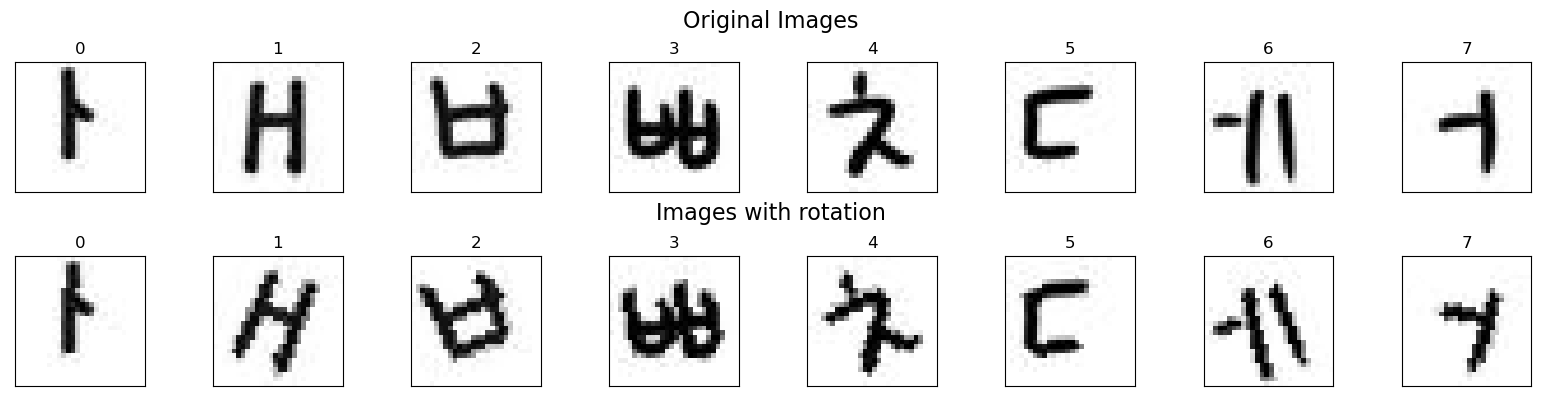

In [82]:
# Create a 2x8 grid of subplots
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Plot original images in the first row
for i in range(8):
    img, label = dataset_unaug[i*80]
    img = img.squeeze().numpy()
    axs[0, i].imshow(img, cmap='gray')
    axs[0, i].set_title(label)
    axs[0, i].axes.xaxis.set_visible(False)
    axs[0, i].axes.yaxis.set_visible(False)

# Plot augmented images in the second row
for i in range(8):
    img, label = dataset_aug[i*80]
    img = img.squeeze().numpy()
    axs[1, i].imshow(img, cmap='gray')
    axs[1, i].set_title(label)
    axs[1, i].axes.xaxis.set_visible(False)
    axs[1, i].axes.yaxis.set_visible(False)

# Add titles for each row of subplots
fig.text(0.5, 0.98, "Original Images", ha='center', fontsize=16, va='top')
fig.text(0.5, 0.5, "Images with rotation", ha='center', fontsize=16, va='top')

plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)

## Implementing a MLP solution

In [5]:
# Define MLP object

class Hangul_MLP(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, input_size, num_classes):
        """
        Constructor for MLP object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(Hangul_MLP, self).__init__()
        # initialize the model weights

        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, (input_size + num_classes) // 2),
            nn.Sigmoid(),
            nn.Linear((input_size + num_classes) // 2, num_classes),
            nn.Sigmoid()
        )
        print(self.linear_stack)

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        out = self.linear_stack(x)
        out = F.softmax(out, dim=1)
        return out


### MLP with batch training

In [148]:
def run_MLP_batch(trainloader, testloader, n_epochs, learning_rate):

    model = Hangul_MLP(input_size = 784, num_classes = 30).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    start = time.time()
    for epoch in range(n_epochs):

        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():

            total_test_loss, total_train_loss, correct_preds = 0.0, 0.0, 0.0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

                test_outputs = model(images)
                test_loss = criterion(test_outputs, labels)
                total_test_loss += test_loss.item()
                
                _, preds = torch.max(test_outputs, 1)
                correct_preds += (preds == labels).sum().item()

            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

                train_outputs = model(images)
                train_loss = criterion(train_outputs, labels)
                total_train_loss += train_loss.item()

            accuracies[epoch] = correct_preds / len(testloader.dataset) * 100 # type: ignore
            test_losses[epoch] = total_test_loss / len(testloader)
            train_losses[epoch] = total_train_loss / len(trainloader)


            print('Epoch: %03d/%03d | Accuracy: %.3f%%' %(epoch + 1, n_epochs, accuracies[epoch]))
        
    print("Total Train Time: %.2f min" % ((time.time() - start)/60))
    return train_losses, test_losses, accuracies, model

In [153]:
train_losses, test_losses, accuracies, _ = run_MLP_batch(train_loader_unaug, test_loader_unaug, 300, 0.8)

Sequential(
  (0): Linear(in_features=784, out_features=407, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=407, out_features=30, bias=True)
  (3): Sigmoid()
)
Epoch: 001/300 | Accuracy: 3.056%
Epoch: 002/300 | Accuracy: 5.139%
Epoch: 003/300 | Accuracy: 18.194%
Epoch: 004/300 | Accuracy: 24.583%
Epoch: 005/300 | Accuracy: 42.639%
Epoch: 006/300 | Accuracy: 50.000%
Epoch: 007/300 | Accuracy: 53.194%
Epoch: 008/300 | Accuracy: 54.583%
Epoch: 009/300 | Accuracy: 57.500%
Epoch: 010/300 | Accuracy: 60.000%
Epoch: 011/300 | Accuracy: 60.278%
Epoch: 012/300 | Accuracy: 61.250%
Epoch: 013/300 | Accuracy: 61.667%
Epoch: 014/300 | Accuracy: 63.472%
Epoch: 015/300 | Accuracy: 60.139%
Epoch: 016/300 | Accuracy: 64.861%
Epoch: 017/300 | Accuracy: 66.250%
Epoch: 018/300 | Accuracy: 66.667%
Epoch: 019/300 | Accuracy: 64.444%
Epoch: 020/300 | Accuracy: 65.833%
Epoch: 021/300 | Accuracy: 66.111%
Epoch: 022/300 | Accuracy: 66.806%
Epoch: 023/300 | Accuracy: 66.389%
Epoch: 024/300 | Accuracy: 67.

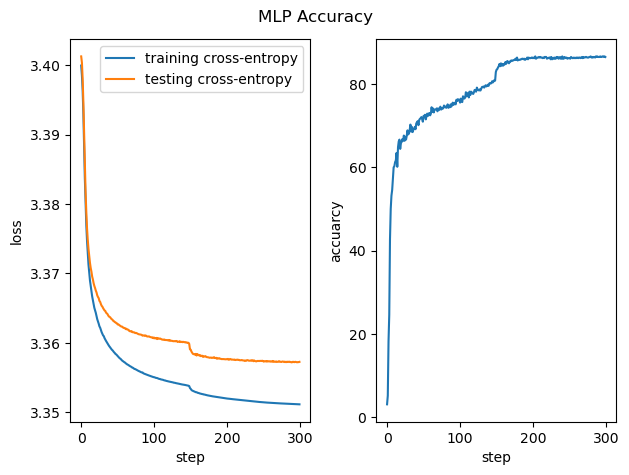

In [155]:
n_epochs = 300

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("MLP Accuracy")
plt.show()

Talk about results here

## Convolutional Neural Network (CNN)

While an MLP can perform image classification, it typically requires the image data to be flattened, which results in the loss of spatial information. Consequently, MLPs generally perform worse on image data compared to CNNs, as they cannot effectively capture spatial features.

CNNs, however, excel at image classification because they preserve the spatial structure of images through convolutional layers. These layers also reduce the number of parameters by sharing weights, enhancing the model's ability to learn intricate patterns. As a result, CNNs tend to achieve higher accuracy and efficiency in image classification tasks, especially when dealing with large-scale datasets and complex visual patterns.

To explore these differences further, we will recreate the LeNet-5 architecture, a CNN structure proposed by LeCun et al. We will assess whether LeNet-5 can outperform the MLP shown above.  

The LeNet-5 Architecture is shown below:  
</br>
<img src="LeNet.png" width="400">  
</br>
By Cmglee - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=104937230

In [105]:
# Define LeNet object

class LeNet(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, num_classes):
        """
        Constructor for LeNet object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(LeNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),

            nn.Linear(in_features= 400, out_features=120),
            nn.ReLU(),

            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),

            nn.Linear(in_features=84, out_features=num_classes)
        )
        print(self.layers)

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        # First Conv Layer
        x = self.layers[0](x)
        x = self.layers[1](x)
        x = self.layers[2](x)  

        # Second Conv Layer
        x = self.layers[3](x)
        x = self.layers[4](x)
        x = self.layers[5](x)  
        
        # Flatten and Fully Connected Layers
        x = self.layers[6](x)
        x = self.layers[7](x)
        x = self.layers[8](x)
        x = self.layers[9](x)
        x = self.layers[10](x)
        x = self.layers[11](x)
        return x



In [126]:
def train_LeNet(trainloader, testloader, n_epochs, learning_rate):
    model = LeNet(num_classes = 30).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    start = time.time()
    for epoch in range(n_epochs):

        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        model.eval()
        with torch.no_grad():

            total_test_loss, total_train_loss, correct_preds = 0.0, 0.0, 0.0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                test_outputs = model(images)
                test_loss = criterion(test_outputs, labels)
                total_test_loss += test_loss.item()
                
                _, preds = torch.max(test_outputs, 1)
                correct_preds += (preds == labels).sum().item()
            
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                train_outputs = model(images)
                train_loss = criterion(train_outputs, labels)
                total_train_loss += train_loss.item()
            
            accuracies[epoch] = correct_preds / len(testloader.dataset) * 100
            test_losses[epoch] = total_test_loss / len(testloader)
            train_losses[epoch] = total_train_loss / len(trainloader)
            
            print('Epoch: %03d/%03d | Accuracy: %.3f%%' %(epoch + 1, n_epochs, accuracies[epoch]))
        
    print("Total Train Time: %.2f min" % ((time.time() - start)/60))
    return train_losses, test_losses, accuracies, model

In [156]:
train_losses, test_losses, accuracies, _ = train_LeNet(train_loader_unaug, test_loader_unaug, 30, 0.002)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=30, bias=True)
)
Epoch: 001/030 | Accuracy: 40.833%
Epoch: 002/030 | Accuracy: 67.500%
Epoch: 003/030 | Accuracy: 80.556%
Epoch: 004/030 | Accuracy: 89.028%
Epoch: 005/030 | Accuracy: 92.083%
Epoch: 006/030 | Accuracy: 90.833%
Epoch: 007/030 | Accuracy: 88.889%
Epoch: 008/030 | Accuracy: 91.944%
Epoch: 009/030 | Accuracy: 90.278%
Epoch: 010/030 | Accuracy: 93.333%
Epoch: 011/030 | Accuracy: 95.556%
Epoch: 012/030 | Accuracy: 92.083%
Epoch: 013/030 | Accuracy: 94.444%
Epoch: 014/030 | Accura

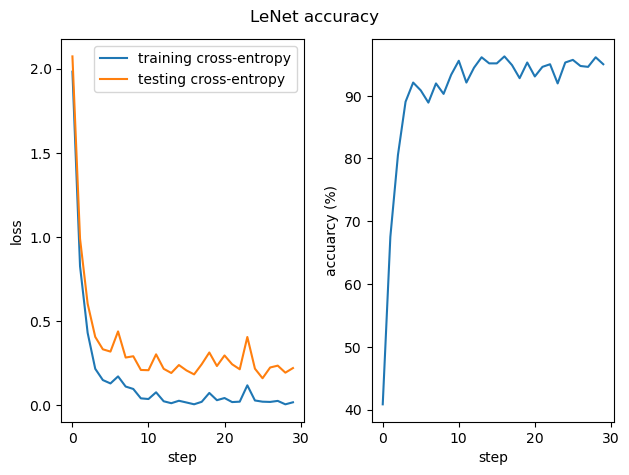

In [158]:
n_epochs = 30

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy (%)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("LeNet accuracy")
plt.show()